# This notebook is a place to collate tests while I am learning Bayesian methodologies

### I am roughly following this textbook: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [6]:
from matplotlib import rc

# The following is code to set defaults for Matplotlib graphs
rc('font',**{'family':'serif','weight':'light', 'size':20})
rc('text', usetex=False)
rc('ytick', labelsize = 15)
rc('xtick', labelsize = 15)
rc('figure', **{'titlesize':20, 'titleweight':'light', 'figsize':(15,8)})
rc('legend', **{'fontsize':20, 'frameon': False})
rc('axes', **{'labelsize':18, 
                'labelweight':'light', 
                'spines.top': 'False', 'spines.right':'False',
                'prop_cycle':  """cycler('color',['2476AB', 'EF9C34', 'D22C2C', 
                            'E5D81D', '8E44AD','1EB22C', '38C6BE','C638A2'])""",
                'titlesize': 25, 'titleweight': 'light'
    })

In [8]:
import pymc3 as pm

In [9]:
from pymc3 import model_to_graphviz
from pymc3 import sample_prior_predictive
from pymc3 import sample

from arviz import plot_posterior
import arviz as az

# Linear Regression

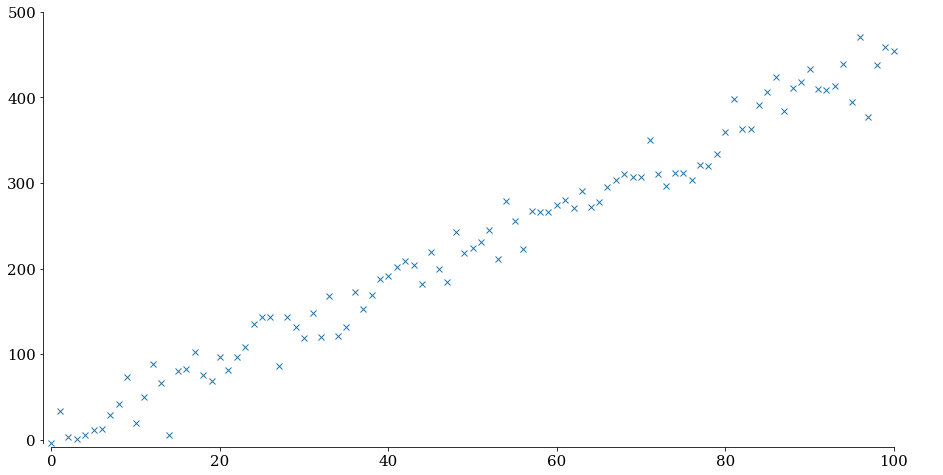

In [10]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100

X = np.linspace(0,100,101)

μ_real = 4.5

# Add a "jitter"
y_true = μ_real * X + pm.Normal.dist(0,20).random(size=len(X))

fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X, y_true, marker= 'x', ls='')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

In [11]:
# Frequentist approach
X_hat = np.array([[1 for i in range(len(X))], X]).T

μ_est_lin = np.linalg.inv(X_hat.T@X_hat) @ X_hat.T @ y_true

In [12]:
def line_reg(beta, x):
    return beta[1]*x[:,1] + beta[0]*x[:,0]

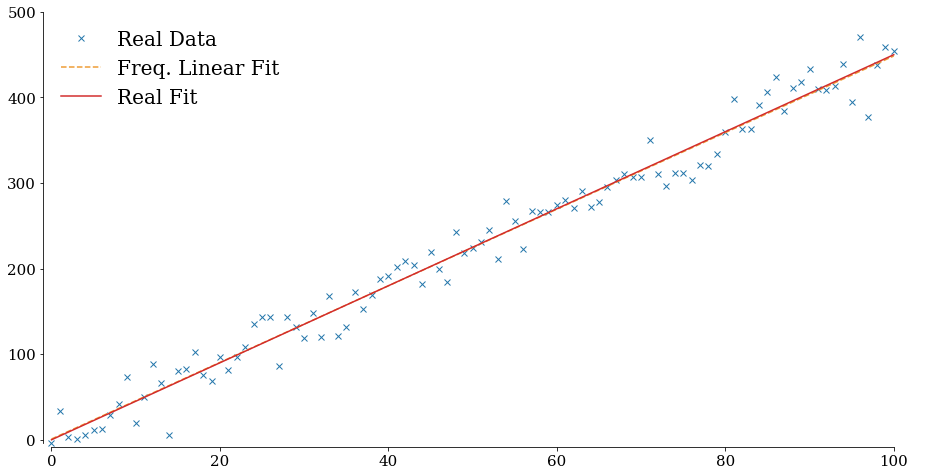

In [13]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X_hat[:,1], y_true, marker= 'x', ls='', label = 'Real Data')
plt.plot(X, line_reg(μ_est_lin, X_hat), ls='--', label = 'Freq. Linear Fit')
plt.plot(X, μ_real*X, label = 'Real Fit')

ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))

plt.legend()

In [15]:
# Bayesian Approach
with pm.Model() as b_linear:
    m = pm.Normal('m', 0, 20)
    c = pm.Normal('c', 0, 10)
    
    σ = pm.HalfNormal('σ', 20)
    
    likelihood = pm.Normal('y', mu = m*X + c, sigma = σ, observed = y_true)

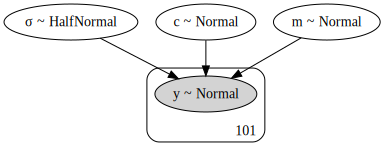

In [16]:
model_to_graphviz(b_linear)

In [18]:
with b_linear:
    prior_sample = sample_prior_predictive(1000)
    samples = sample(1000, tune=1000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1700.33draws/s]


/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/joseph_cross/Anaconda/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


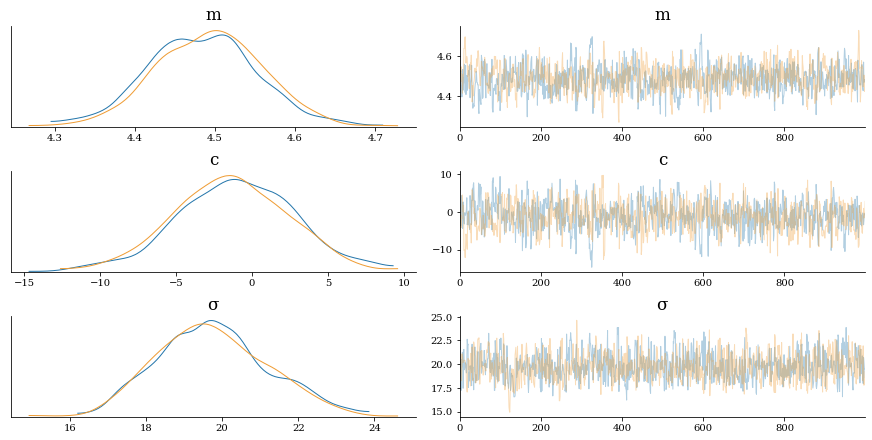

In [19]:
az.plot_trace(samples);

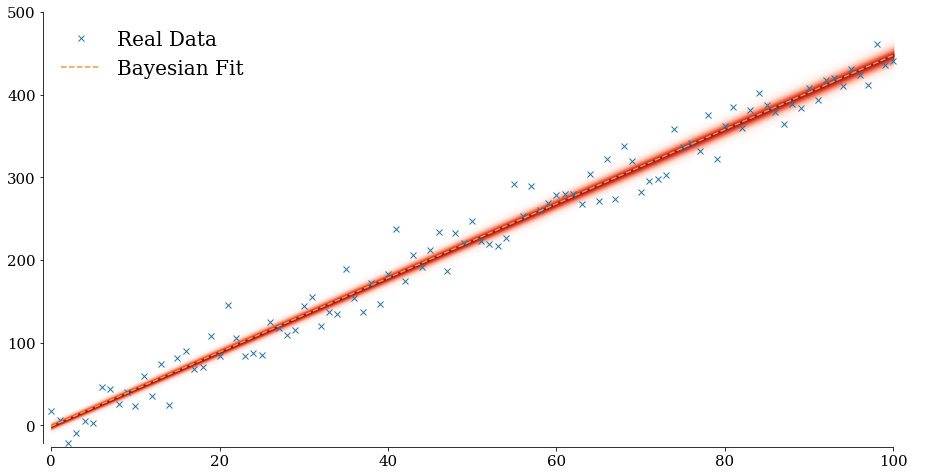

In [27]:
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(X, y_true, marker= 'x', ls='', label = 'Real Data')
plt.plot(X, line_reg([samples['c'].mean(), samples['m'].mean()], X_hat), ls='--', label = 'Bayesian Fit')
x = X
fill_alpha = 0.1
palette = 'Reds'
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

for i, p in enumerate(percs[::-1]):
    upper_m = np.percentile(samples['m'], p)
    lower_m = np.percentile(samples['m'], 100-p)
    
    upper_c = np.percentile(samples['c'], p)
    lower_c = np.percentile(samples['c'], 100-p)
    
    y_upper = upper_m * x + upper_c
    y_lower = lower_m * x + lower_c
    
    color_val = colors[i]
    
    ax.fill_between(x, y_upper, y_lower, color=cmap(color_val), alpha=fill_alpha)
ax.set_xlim(X.min()-(X.max() - X.min())/100)
ax.set_ylim(y_true.min()-(roundup(y_true.max() - y_true.min())/100), roundup(y_true.max()))

ax.spines['bottom'].set_bounds(X.min(), X.max())
ax.spines['left'].set_bounds(y_true.min(), roundup(y_true.max()))
plt.legend()
plt.show()

## Poisson / Count